In [5]:
import pandas as pd
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# Data Exploation
LB - FHR baseline (beats per minute) <br>
AC - # of accelerations per second <br> 
FM - # of fetal movements per second <br> 
UC - # of uterine contractions per second <br> 
DL - # of light decelerations per second <br> 
DS - # of severe decelerations per second <br> 
DP - # of prolongued decelerations per second <br> 
ASTV - percentage of time with abnormal short term variability <br> 
MSTV - mean value of short term variability <br> 
ALTV - percentage of time with abnormal long term variability <br> 
MLTV - mean value of long term variability <br> 
Width - width of FHR histogram <br> 
Min - minimum of FHR histogram <br> 
Max - Maximum of FHR histogram <br> 
Nmax - # of histogram peaks <br> 
Nzeros - # of histogram zeros <br> 
Mode - histogram mode <br> 
Mean - histogram mean <br> 
Median - histogram median <br> 
Variance - histogram variance <br> 
Tendency - histogram tendency <br> 
CLASS - FHR pattern class code (1 to 10) <br> 
__NSP - fetal state class code (N=normal; S=suspect; P=pathologic)__<br> 



In [6]:
train = pd.read_csv("/home/kaiyuewang/Machine-Learning/fetal-hr.csv")
# since the goal of this experienment is just to analyze the fetal state (ie. N, S, P). We will drop unncessary features to reduce complexity of the data
train = train.drop(['Unnamed: 9', 'Unnamed: 31', 'Unnamed: 42', 'Unnamed: 44', 'A', 'B', 'C', 'D', 'E', 'AD', 'DE', 'LD', 'FS', 'SUSP', 'CLASS'], axis=1)
train = train.drop(train.index[2126:])
train['Time'] = train['e'].sub(train['b'], axis=0)
train = train.drop(['b', 'e'], axis=1)  # instead of using start and end feature, we can reduce the feature dimensionality by just calculating the interval

print (train.columns)  # number of features available


Index(['AC', 'FM', 'UC', 'DL', 'DS', 'DP', 'DR', 'LB', 'AC.1', 'FM.1', 'UC.1',
       'DL.1', 'DS.1', 'DP.1', 'ASTV', 'MSTV', 'ALTV', 'MLTV', 'Width', 'Min',
       'Max', 'Nmax', 'Nzeros', 'Mode', 'Mean', 'Median', 'Variance',
       'Tendency', 'NSP', 'Time'],
      dtype='object')


In [91]:
import sklearn
list_to_normalize = list(set(train.columns.values) - set(['NSP']))
# print (list_to_normalize)
# std_scale = preprocessing.StandardScaler().fit(train[list_to_normalize])
# df_std = std_scale.transform(train[list_to_normalize])

# minmax_scale = preprocessing.MinMaxScaler().fit(train[list_to_normalize])
# df_minmax = minmax_scale.transform(train[list_to_normalize])

In [110]:
def accuracies_vs_trainsize(X_train, y_train, X_test, y_test, classifier_creation_func, accuracy_evaluation_func):
    training_accuracies = []
    testing_accuracies = []
    size_training = [X_train.shape[0] // i for i in range(5, 0, -1)] # sample 5 equally divided datapoints length
    indexes = [np.random.choice(X_train.shape[0], n, replace=False) for n in size_training]
    for index in indexes:
        print ("====================== {} ===============".format(index.shape))
        
        classifier = classifier_creation_func(index.shape[0])
        xtrain = X_train[index]
        ytrain = y_train[index]
                
        training_accuracy, predict_accuracy = accuracy_evaluation_func(xtrain, ytrain, X_test, y_test, classifier)
        
        training_accuracies.append(training_accuracy)
        testing_accuracies.append(predict_accuracy)
    
    # plot the size vs accuracy data
    plt.plot(size_training, training_accuracies)
    plt.plot(size_training, testing_accuracies)
    plt.legend(['training_accuracy', 'testing_accuracy'])
    plt.ylabel('accuracies')
    plt.xlabel('train size')

# Ada Boost

In [116]:
from sklearn.model_selection import train_test_split
y = train['NSP'].values
X = train[list_to_normalize].values
print (X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

(2126, 29) (2126,)


====================== (297,) ===============
====================== (372,) ===============
====================== (496,) ===============
====================== (744,) ===============
====================== (1488,) ===============


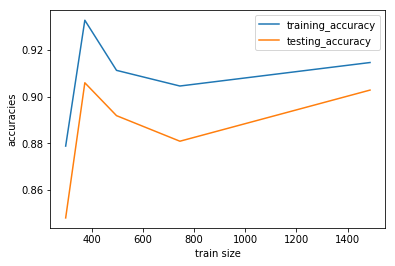

In [117]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import metrics
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from subprocess import check_output
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

# experienment on the best hyper parameters

# param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
#               "base_estimator__splitter" :   ["best", "random"],
#               "n_estimators": [i for i in range(200, 1000, 100)],
              
#              }
# ada_classifier.fit(X_train, y_train)
# # grid_search_ABC = GridSearchCV(ada_classifier, param_grid=param_grid, scoring = 'roc_auc')
# # print (grid_search_ABC)
# training_accuracy = metrics.accuracy_score(ada_classifier.predict(X_train), y_train)
# print (training_accuracy)



# test on the best hyper parameters
def accuracy_evaluation(xtrain, ytrain, xtest, ytest, classifier):
    classifier.fit(xtrain, ytrain)
    train_acc = metrics.accuracy_score(classifier.predict(xtrain), ytrain)
    test_acc = metrics.accuracy_score(classifier.predict(X_test), y_test)
    return train_acc, test_acc

def classifier_generator(size):
    return AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=200, algorithm="SAMME.R", learning_rate=0.05)
    
accuracies_vs_trainsize(X_train, y_train, X_test, y_test, classifier_generator, accuracy_evaluation)


# Neural Network

[[1 0 0]
 [1 0 0]
 [1 0 0]
 ...
 [0 1 0]
 [1 0 0]
 [1 0 0]]
====================== (297,) ===============
(297, 29)
638/638 [==============================] - 0s 27us/step
====================== (372,) ===============
(372, 29)
638/638 [==============================] - 0s 27us/step
====================== (496,) ===============
(496, 29)
638/638 [==============================] - 0s 26us/step
====================== (744,) ===============
(744, 29)
638/638 [==============================] - 0s 25us/step
====================== (1488,) ===============
(1488, 29)
638/638 [==============================] - 0s 24us/step


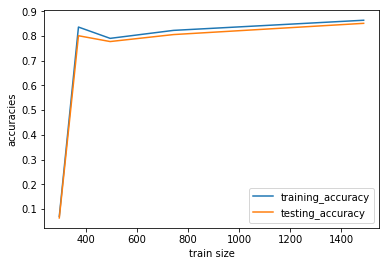

In [118]:
#Neural Network
from keras import models
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import SGD, Adam, RMSprop
import livelossplot
from sklearn.preprocessing import LabelBinarizer
plot_losses = livelossplot.PlotLossesKeras()
%matplotlib inline

# Categorically encode labels
lb = LabelBinarizer()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, shuffle=True)
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)
print (y_test)
# Check state of datase
learning_rate = 0.00005
EPOCHS = 20
BATCH_SIZE = 1000

def classifier_generator(size):
    model = models.Sequential()
    model.add(Dense(256, activation='relu', input_shape=(X_train.shape[1], )))
    # model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    # model.add(Dense(64, activation='relu'))

    # model.add(Dropout(0.25))
    model.add(Dense(3, activation='softmax'))

    opt = Adam(lr=learning_rate)

    # Compile model
    model.compile(optimizer=opt,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


def accuracy_evaluation(xtrain, ytrain, xtest, ytest, classifier):
    print (xtrain.shape)
    classifier.fit(xtrain, ytrain, batch_size=32, epochs=EPOCHS, verbose=0, validation_data=(X_test, y_test))
    return classifier.evaluate(xtrain, ytrain)[1], classifier.evaluate(X_test, y_test)[1]
    
accuracies_vs_trainsize(X_train, y_train, X_test, y_test, classifier_generator, accuracy_evaluation)


# Decision Tree

In [72]:
from sklearn import tree
from IPython.display import Image
import os
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

from sklearn.tree._tree import TREE_LEAF

def prune_index(inner_tree, index, threshold):
    if inner_tree.value[index].min() < threshold:
        # turn node into a leaf by "unlinking" its children
        inner_tree.children_left[index] = TREE_LEAF
        inner_tree.children_right[index] = TREE_LEAF
    # if there are shildren, visit them as well
    if inner_tree.children_left[index] != TREE_LEAF:
        prune_index(inner_tree, inner_tree.children_left[index], threshold)
        prune_index(inner_tree, inner_tree.children_right[index], threshold)

print(sum(clf.tree_.children_left < 0))
# start pruning from the root
prune_index(clf.tree_, 0, 5)
sum(clf.tree_.children_left < 0)

82


92

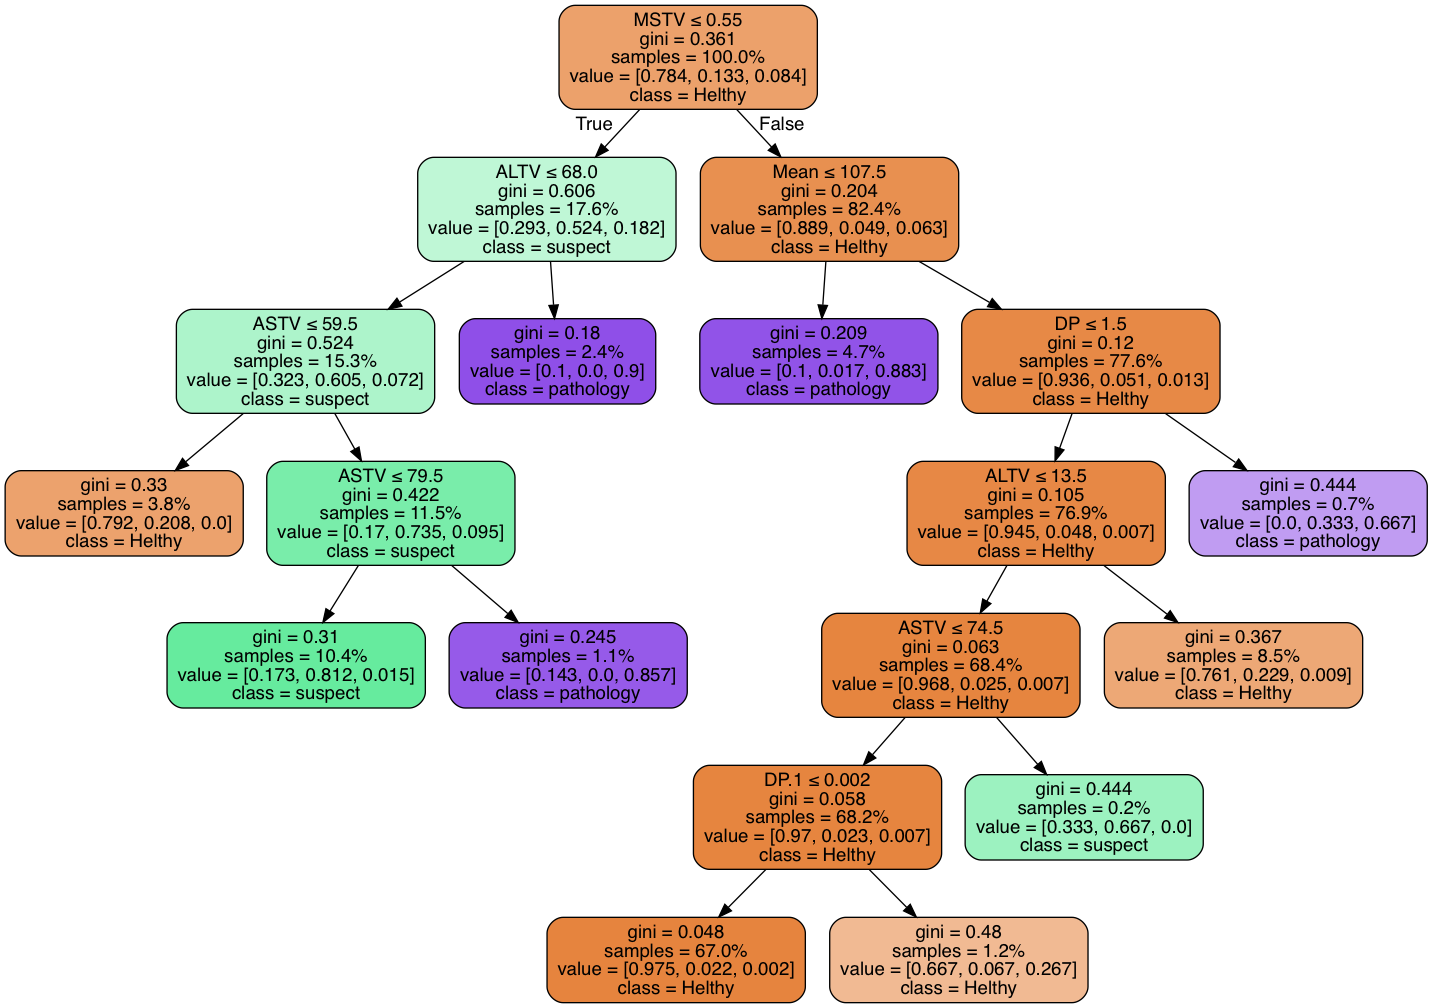

In [73]:
def plot_tree(clf,feature_names):
    tree.export_graphviz(clf,out_file='tree.dot',class_names=['Helthy','suspect', 'pathology'],feature_names=feature_names, 
                         filled=True, rounded=True, special_characters=True, proportion=True)
    os.system("dot -Tpng tree.dot -o tree.png")
    os.system("tree.png")
plot_tree(clf, list_to_normalize)
# Note : Uncoverted Quotes (Yes) and Converted quotes (No)
Image(filename='tree.png')

In [74]:
from sklearn.metrics import accuracy_score
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9106933019976499

Text(0.5,0,'train size')

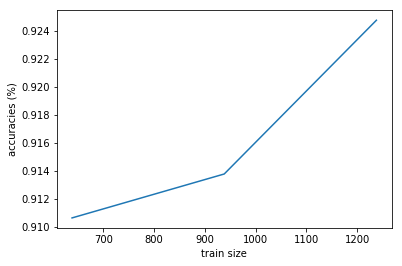

In [72]:
sizes = range(X_test.shape[0], X_train.shape[0], 300)
accuracies = []
for size in sizes:
    curXtrain, curYtrain = X_train[:size], y_train[:size]
    decisionTree = DecisionTreeClassifier(max_depth=15)
    decisionTree.fit(curXtrain, curYtrain)
    y_pred = decisionTree.predict(X_test)
    accuracies.append(metrics.accuracy_score(y_test, y_pred))
plt.plot(sizes, accuracies)
plt.ylabel('accuracies (%)')
plt.xlabel('train size')

0.780241935483871
0.8588709677419355
0.9112903225806451
0.9247311827956989
0.9301075268817204
0.9596774193548387
0.9744623655913979
0.9872311827956989
0.991263440860215
0.9946236559139785
0.9979838709677419
0.9986559139784946
0.9986559139784946
0.9986559139784946


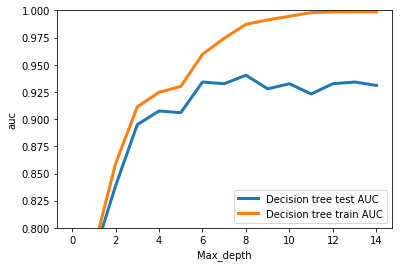

<Figure size 864x864 with 0 Axes>

In [69]:
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from IPython.display import Image
from sklearn import tree
import os
depth = 15
tree_auc_trn, tree_auc_tst = np.zeros(depth), np.zeros(depth)
for i in range(1,depth):
    clf1 = tree.DecisionTreeClassifier(max_depth=i, criterion='entropy')
    clf1 = clf1.fit(X_train, y_train)
    y_pred = clf1.predict(X_test)
    
    y_train_pred = clf1.predict(X_train)
    testScore = metrics.accuracy_score(y_test, y_pred)
    trainScore = metrics.accuracy_score(y_train, y_train_pred)
    print (trainScore)
    tree_auc_trn[i] = trainScore
    tree_auc_tst[i] = testScore

from matplotlib import pyplot
pyplot.plot(tree_auc_tst, linewidth=3, label = "Decision tree test AUC")
pyplot.plot(tree_auc_trn, linewidth=3, label = "Decision tree train AUC")
pyplot.legend()
pyplot.ylim(0.8, 1.0)
pyplot.xlabel("Max_depth")
pyplot.ylabel("auc")
plt.figure(figsize=(12,12))
pyplot.show()

ValueError: multiclass format is not supported

<Figure size 432x288 with 0 Axes>

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn import datasets
from skimage import exposure
import numpy as np
import imutils
import cv2
import sklearn
from multiprocessing import Process, Queue, Lock

# initialize the values of k for our k-Nearest Neighbor classifier along with the
# list of accuracies for each value of k
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)
# lock = Lock()
# testX, testY, trainX, trainY = testX[:100], testY[:100], trainX[:100], trainY[:100]
def K_nearest_neighbors(K):
#     lock.acquire()
#     try:
    # train the k-Nearest Neighbor classifier with the current value of `k`
    model = KNeighborsClassifier(n_neighbors=K)
    model.fit(X_train, y_train)

    # evaluate the model and update the accuracies list
    score = model.score(X_test, y_test)
    print("k=%d, accuracy=%.2f%%" % (k, score * 100))
#     accuracies.put(score)
#     finally:
#         lock.release()

processes = [] 
# loop over various values of `k` for the k-Nearest Neighbor classifier
for k in range(1, 30, 2):
    p = Process(target=K_nearest_neighbors, args=(k,))
    processes.append(p)
    p.start()

for i in processes:
    i.join()

k=1, accuracy=83.23%
k=3, accuracy=84.01%
k=5, accuracy=83.23%
k=7, accuracy=83.07%
k=9, accuracy=83.23%
k=11, accuracy=82.76%
k=13, accuracy=81.97%
k=15, accuracy=81.50%
k=17, accuracy=81.35%
k=19, accuracy=80.72%
k=21, accuracy=81.19%
k=23, accuracy=80.56%
k=25, accuracy=80.25%
k=27, accuracy=79.94%
k=29, accuracy=79.62%


In [18]:
def K_nearest_neighbors(train_X, train_y, test_X, test_y):
#     lock.acquire()
#     try:
    # train the k-Nearest Neighbor classifier with the current value of `k`
    model = KNeighborsClassifier(n_neighbors=3)
    model.fit(train_X, train_y)

    # evaluate the model and update the accuracies list
    score = model.score(test_X, test_y)
    print("train_size=%d, accuracy=%.2f%%" % (train_X.shape[0], score * 100))
    accuracies.append(score * 100)
    

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=217, random_state=42, shuffle=True)
accuracies = []
trainSizes = range(1000, X_train.shape[0], 100)
print (trainSizes)

for i in trainSizes:
    curTrainX = X_train[:i]
    curTrainY = y_train[:i]
    K_nearest_neighbors(curTrainX, curTrainY, X_test, y_test)

print(accuracies)
    

range(1000, 1909, 100)
train_size=1000, accuracy=82.95%
train_size=1100, accuracy=84.33%
train_size=1200, accuracy=83.87%
train_size=1300, accuracy=85.25%
train_size=1400, accuracy=85.25%
train_size=1500, accuracy=85.25%
train_size=1600, accuracy=85.71%
train_size=1700, accuracy=85.25%
train_size=1800, accuracy=85.25%
train_size=1900, accuracy=84.33%
[82.94930875576037, 84.33179723502305, 83.87096774193549, 85.25345622119815, 85.25345622119815, 85.25345622119815, 85.71428571428571, 85.25345622119815, 85.25345622119815, 84.33179723502305]


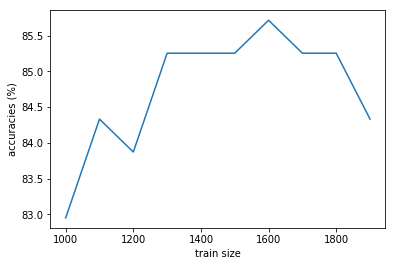

In [19]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
def plot_accuracy_vs_trainSize(accuracy, trainSize):
    assert(len(accuracy) == len(trainSize))
    plt.plot(trainSize, accuracy)
    plt.ylabel('accuracies (%)')
    plt.xlabel('train size')


plot_accuracy_vs_trainSize(accuracies, trainSizes)

# SVM

In [89]:
# SVM Helper
#https://github.com/ksopyla/svm_mnist_digit_classification/blob/master/mnist_helpers.py

# Standard scientific Python imports
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import numpy as np

def show_some_digits(images, targets, sample_size=24, title_text='Digit {}' ):
    '''
    Visualize random digits in a grid plot
    images - array of flatten gidigs [:,784]
    targets - final labels
    '''
    nsamples=sample_size
    rand_idx = np.random.choice(images.shape[0],nsamples)
    images_and_labels = list(zip(images[rand_idx], targets[rand_idx]))


    img = plt.figure(1, figsize=(15, 12), dpi=160)
    for index, (image, label) in enumerate(images_and_labels):
        plt.subplot(np.ceil(nsamples/6.0), 6, index + 1)
        plt.axis('off')
        #each image is flat, we have to reshape to 2D array 28x28-784
        plt.imshow(image.reshape(28,28), cmap=plt.cm.gray_r, interpolation='nearest')
        plt.title(title_text.format(label))

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    Plots confusion matrix, 
    
    cm - confusion matrix
    """
    plt.figure(1, figsize=(15, 12), dpi=160)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')    
    


class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

def plot_param_space_scores(scores, C_range, gamma_range):
    """
    Draw heatmap of the validation accuracy as a function of gamma and C
    
    
    Parameters
    ----------
    scores - 2D numpy array with accuracies
    
    """
    #
    # The score are encoded as colors with the hot colormap which varies from dark
    # red to bright yellow. As the most interesting scores are all located in the
    # 0.92 to 0.97 range we use a custom normalizer to set the mid-point to 0.92 so
    # as to make it easier to visualize the small variations of score values in the
    # interesting range while not brutally collapsing all the low score values to
    # the same color.

    
    plt.figure(figsize=(8, 6))
    plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
    plt.imshow(scores, interpolation='nearest', cmap=plt.cm.jet,
               norm=MidpointNormalize(vmin=0.5, midpoint=0.9))
    plt.xlabel('gamma')
    plt.ylabel('C')
    plt.colorbar()
    plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
    plt.yticks(np.arange(len(C_range)), C_range)
    plt.title('Validation accuracy')
    plt.show()

Start param searching at 2018-09-24 03:28:43.328845
Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] kernel=rbf, gamma=0.001, C=0.1 ..................................
[CV] ................... kernel=rbf, gamma=0.001, C=0.1, total=   0.1s
[CV] kernel=rbf, gamma=0.001, C=0.1 ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] ................... kernel=rbf, gamma=0.001, C=0.1, total=   0.1s
[CV] kernel=rbf, gamma=0.001, C=0.1 ..................................
[CV] ................... kernel=rbf, gamma=0.001, C=0.1, total=   0.1s
[CV] kernel=rbf, gamma=0.005, C=0.1 ..................................
[CV] ................... kernel=rbf, gamma=0.005, C=0.1, total=   0.2s
[CV] kernel=rbf, gamma=0.005, C=0.1 ..................................
[CV] ................... kernel=rbf, gamma=0.005, C=0.1, total=   0.2s
[CV] kernel=rbf, gamma=0.005, C=0.1 ..................................
[CV] ................... kernel=rbf, gamma=0.005, C=0.1, total=   0.2s
[CV] kernel=rbf, gamma=0.01, C=0.1 ...................................
[CV] .................... kernel=rbf, gamma=0.01, C=0.1, total=   0.2s
[CV] kernel=rbf, gamma=0.01, C=0.1 ...................................
[CV] .................... kernel=rbf, gamma=0.01, C=0.1, total=   0.2s
[CV] kernel=rbf, gamma=0.01, C=0.1 ...................................
[CV] .

[CV] ..................... kernel=rbf, gamma=0.1, C=1.0, total=   0.1s
[CV] kernel=rbf, gamma=0.1, C=1.0 ....................................
[CV] ..................... kernel=rbf, gamma=0.1, C=1.0, total=   0.1s
[CV] kernel=rbf, gamma=0.1, C=1.0 ....................................
[CV] ..................... kernel=rbf, gamma=0.1, C=1.0, total=   0.1s
[CV] kernel=rbf, gamma=0.5, C=1.0 ....................................
[CV] ..................... kernel=rbf, gamma=0.5, C=1.0, total=   0.1s
[CV] kernel=rbf, gamma=0.5, C=1.0 ....................................
[CV] ..................... kernel=rbf, gamma=0.5, C=1.0, total=   0.1s
[CV] kernel=rbf, gamma=0.5, C=1.0 ....................................
[CV] ..................... kernel=rbf, gamma=0.5, C=1.0, total=   0.1s
[CV] kernel=rbf, gamma=1.0, C=1.0 ....................................
[CV] ..................... kernel=rbf, gamma=1.0, C=1.0, total=   0.1s
[CV] kernel=rbf, gamma=1.0, C=1.0 ....................................
[CV] .

[CV] .................... kernel=rbf, gamma=5.0, C=10.0, total=   0.1s
[CV] kernel=rbf, gamma=5.0, C=10.0 ...................................
[CV] .................... kernel=rbf, gamma=5.0, C=10.0, total=   0.1s
[CV] kernel=rbf, gamma=0.001, C=50.0 .................................
[CV] .................. kernel=rbf, gamma=0.001, C=50.0, total=   0.2s
[CV] kernel=rbf, gamma=0.001, C=50.0 .................................
[CV] .................. kernel=rbf, gamma=0.001, C=50.0, total=   0.2s
[CV] kernel=rbf, gamma=0.001, C=50.0 .................................
[CV] .................. kernel=rbf, gamma=0.001, C=50.0, total=   0.2s
[CV] kernel=rbf, gamma=0.005, C=50.0 .................................
[CV] .................. kernel=rbf, gamma=0.005, C=50.0, total=   0.2s
[CV] kernel=rbf, gamma=0.005, C=50.0 .................................
[CV] .................. kernel=rbf, gamma=0.005, C=50.0, total=   0.2s
[CV] kernel=rbf, gamma=0.005, C=50.0 .................................
[CV] .

[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed:   28.1s finished


Elapsed time, param searching 0:00:28.416927


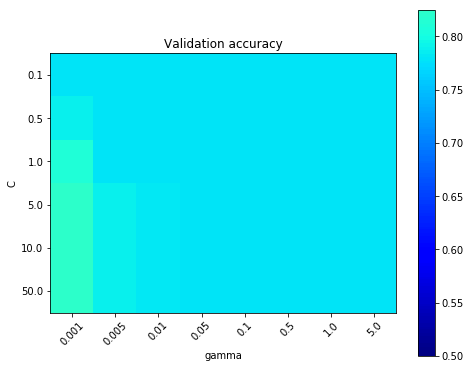

In [90]:
# SVM
# Standard scientific Python imports
import matplotlib.pyplot as plt
import numpy as np
import time
import datetime as dt

# Import datasets, classifiers and performance metrics
from sklearn import datasets, svm, metrics
#fetch original mnist dataset
from sklearn.datasets import fetch_mldata

############### Classification with grid search ##############
# If you don't want to wait, comment this section and uncommnet section below with
# standalone SVM classifier

# Warning! It takes really long time to compute this about 2 days

# Create parameters grid for RBF kernel, we have to set C and gamma
from sklearn.model_selection import GridSearchCV

# generate matrix with all gammas
# [ [10^-4, 2*10^-4, 5*10^-4], 
#   [10^-3, 2*10^-3, 5*10^-3],
#   ......
#   [10^3, 2*10^3, 5*10^3] ]
#gamma_range = np.outer(np.logspace(-4, 3, 8),np.array([1,2, 5]))
gamma_range = np.outer(np.logspace(-3, 0, 4),np.array([1,5]))
gamma_range = gamma_range.flatten()

# generate matrix with all C
#C_range = np.outer(np.logspace(-3, 3, 7),np.array([1,2, 5]))
C_range = np.outer(np.logspace(-1, 1, 3),np.array([1,5]))
# flatten matrix, change to 1D numpy array
C_range = C_range.flatten()

parameters = {'kernel':['rbf'], 'C':C_range, 'gamma': gamma_range}

svm_clsf = svm.SVC()
grid_clsf = GridSearchCV(estimator=svm_clsf,param_grid=parameters,n_jobs=1, verbose=2)


start_time = dt.datetime.now()
print('Start param searching at {}'.format(str(start_time)))

grid_clsf.fit(X_train, y_train)

elapsed_time= dt.datetime.now() - start_time
print('Elapsed time, param searching {}'.format(str(elapsed_time)))
sorted(grid_clsf.cv_results_.keys())

classifier = grid_clsf.best_estimator_
params = grid_clsf.best_params_



scores = grid_clsf.cv_results_['mean_test_score'].reshape(len(C_range),
                                                     len(gamma_range))

plot_param_space_scores(scores, C_range, gamma_range)

Classification report for classifier SVC(C=5.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

        1.0       0.86      0.95      0.90       494
        2.0       0.57      0.47      0.51        86
        3.0       0.90      0.33      0.48        58

avg / total       0.82      0.83      0.81       638


Confusion matrix:
[[470  22   2]
 [ 46  40   0]
 [ 31   8  19]]
Accuracy=0.829153605015674


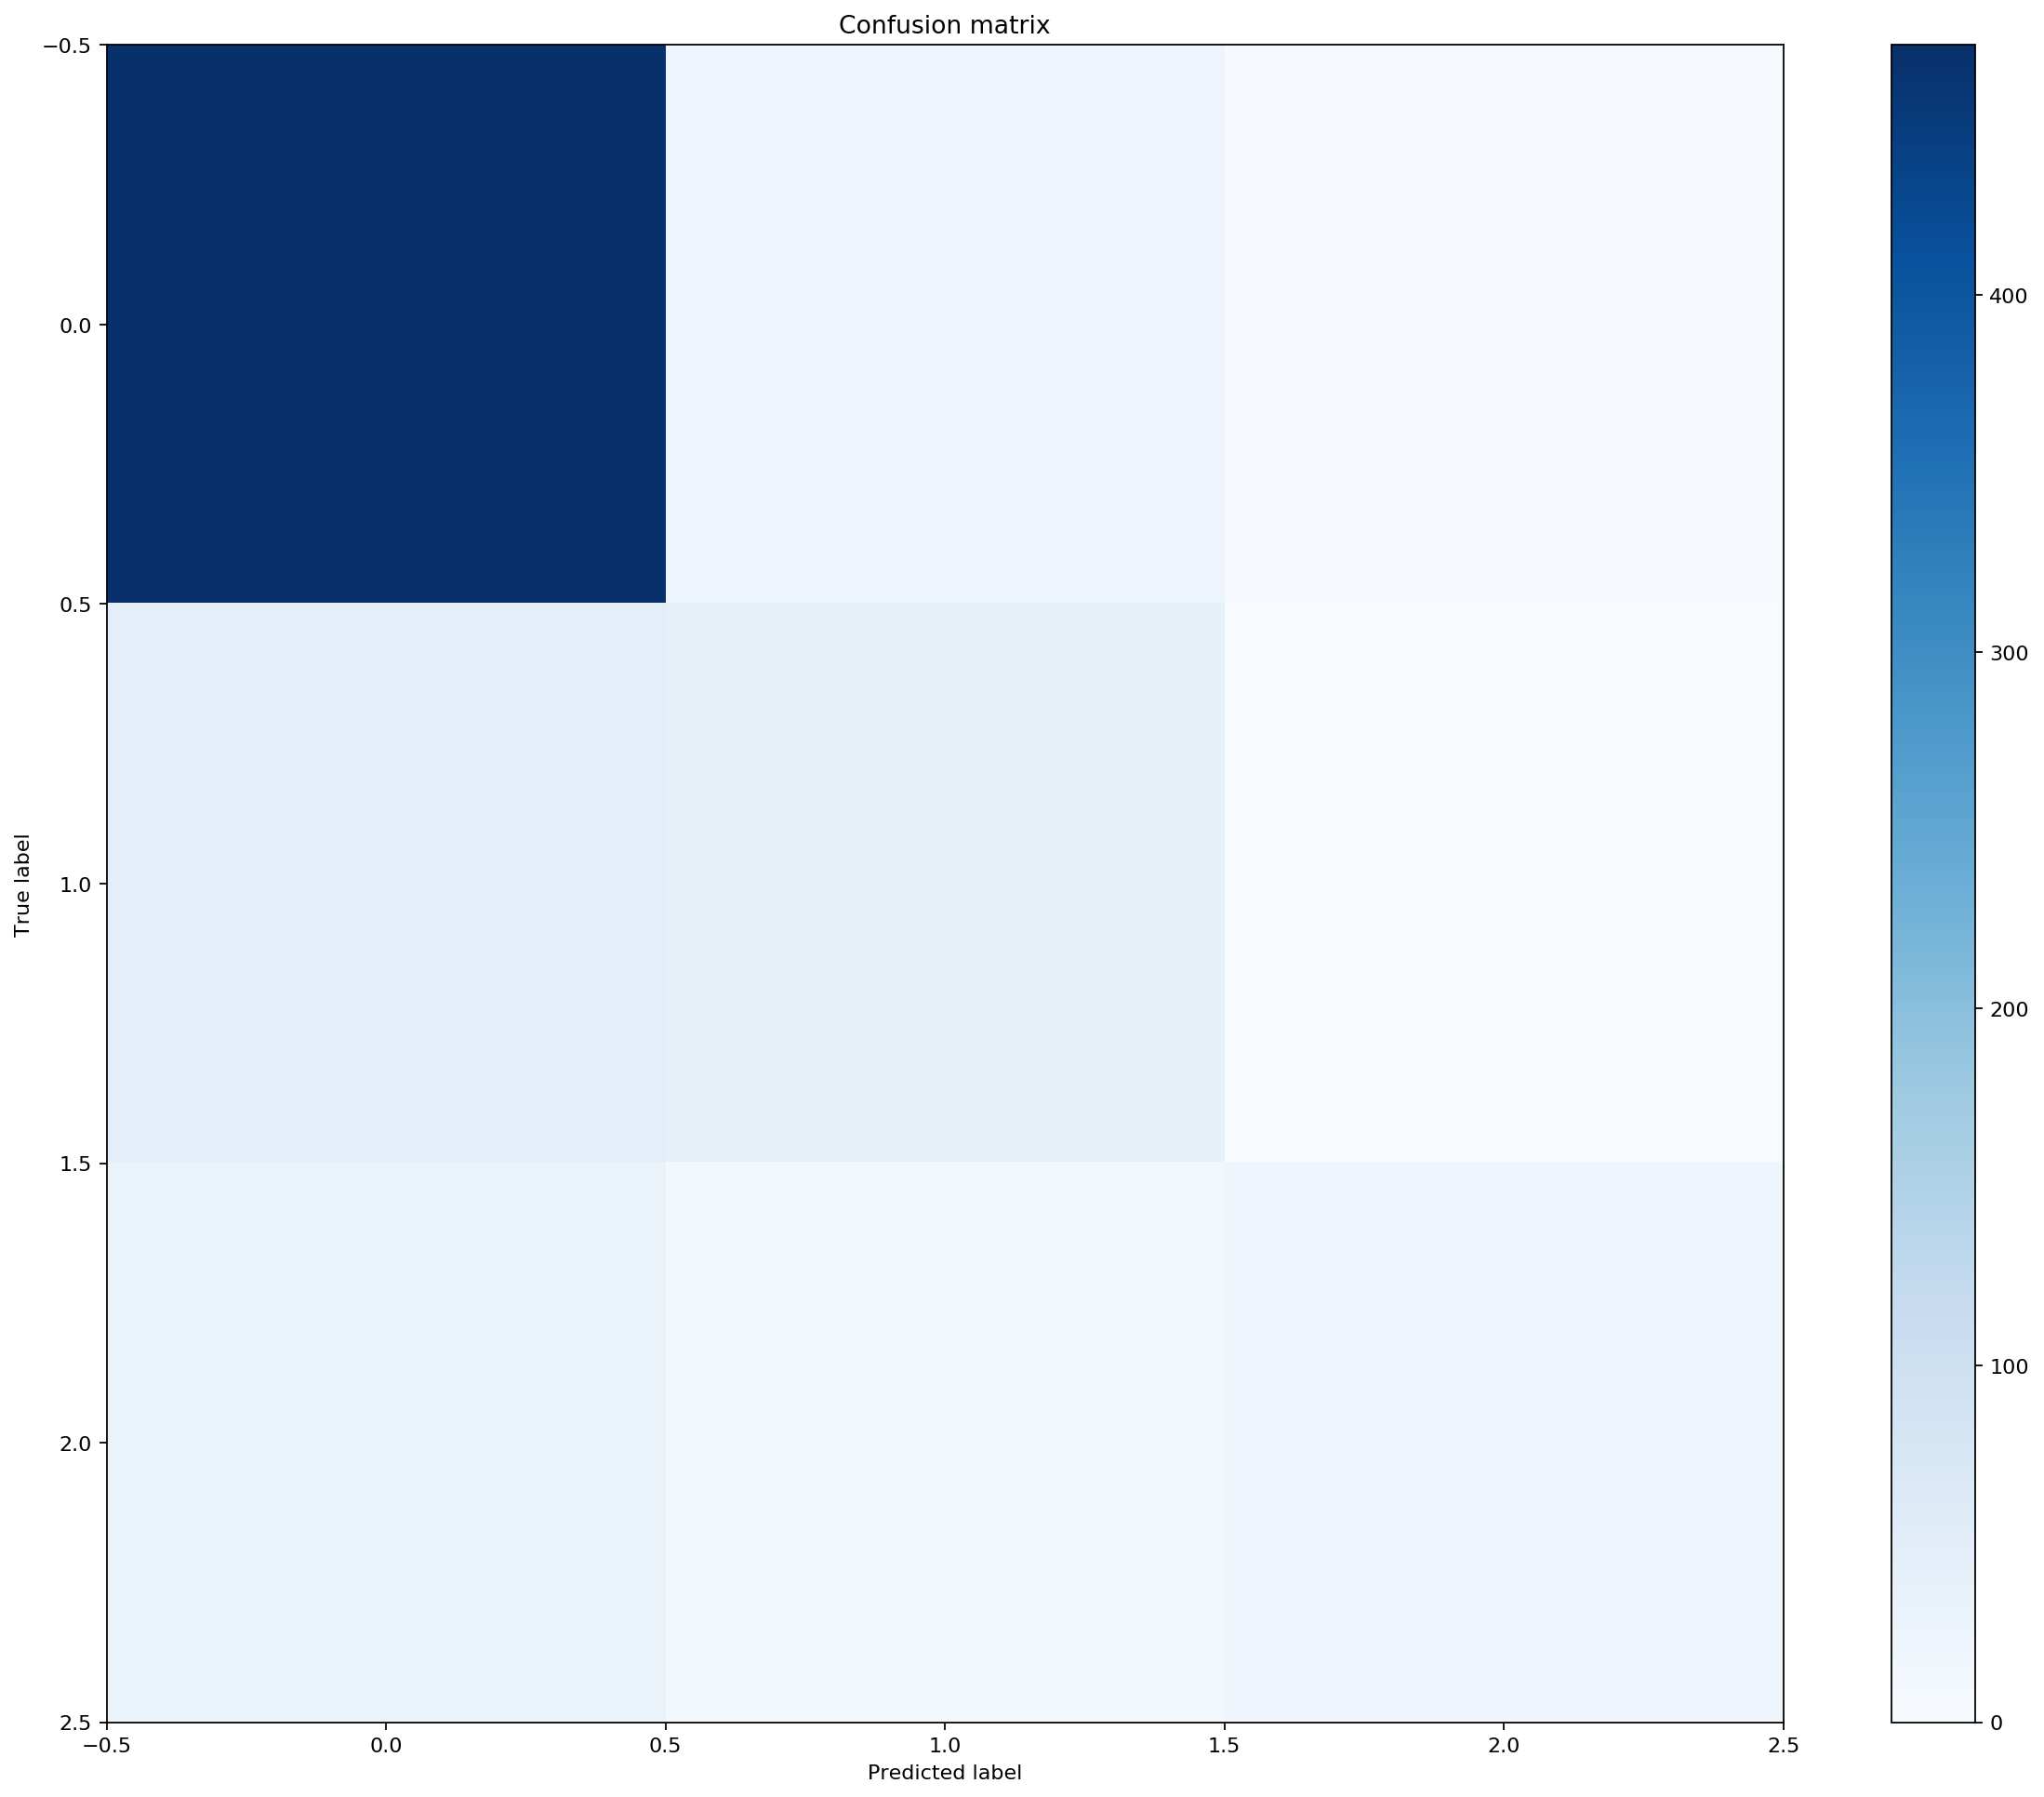

In [92]:
expected = y_test
predicted = classifier.predict(X_test)


print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(expected, predicted)))
      
cm = metrics.confusion_matrix(expected, predicted)
print("Confusion matrix:\n%s" % cm)

plot_confusion_matrix(cm)

print("Accuracy={}".format(metrics.accuracy_score(expected, predicted)))


In [93]:
import numpy as np
import time
import datetime as dt

# Import datasets, classifiers and performance metrics
from sklearn import datasets, svm, metrics
#fetch original mnist dataset
from sklearn.datasets import fetch_mldata


Start learning at 2018-09-24 03:41:29.176658


Text(0.5,0,'train size')

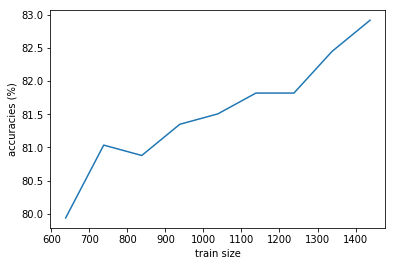

In [94]:
param_C = 5
param_gamma = 0.001

start_time = dt.datetime.now()
print('Start learning at {}'.format(str(start_time)))

sizes = range(X_test.shape[0], X_train.shape[0], 100)
accuracies = []
for size in sizes:
    classifier = svm.SVC(C=param_C,gamma=param_gamma)
    curXtrain, curYtrain = X_train[:size], y_train[:size]
    classifier.fit(curXtrain, curYtrain)
    expected = y_test
    predicted = classifier.predict(X_test)
    
    accuracies.append(metrics.accuracy_score(expected, predicted) * 100)
plt.plot(sizes, accuracies)
plt.ylabel('accuracies (%)')
plt.xlabel('train size')


